# Import Dependancies

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Data Loading & Preprocessing

In [2]:
# Load the data
data = pd.read_csv('/kaggle/input/bengaluru-house-price-dataset/bengaluru_house_prices.csv')
# Display the first few rows of the dataset
data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
# Check size of the data
print("Shape of the data:", data.shape)

Shape of the data: (13320, 9)


In [4]:
# Check for missing values
print("Missing values:")
print(data.isnull().sum())

Missing values:
area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64


In [5]:
#Replace null values with empty string
data = data.fillna('')

In [6]:
# Standardize 'size' column: convert "Bedroom" to "BHK"
data['size'] = data['size'].str.replace('Bedroom', 'BHK')

# Filter out any rows where 'size' is not in the expected format
data = data[data['size'].str.contains('BHK|Bedroom', na=False)]

# Extract number of BHK from 'size' column
data['size'] = data['size'].apply(lambda x: int(x.split()[0]))

# Convert 'total_sqft' to numerical format
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

data['total_sqft'] = data['total_sqft'].apply(convert_sqft_to_num)

# Drop rows with missing 'total_sqft'
data = data.dropna(subset=['total_sqft'])

# Exploratory Data Analysis (EDA)

In [7]:
# Calculate median price for each location
median_prices = data.groupby('location')['price'].median().sort_values(ascending=False)
top_locations = median_prices.head(20)

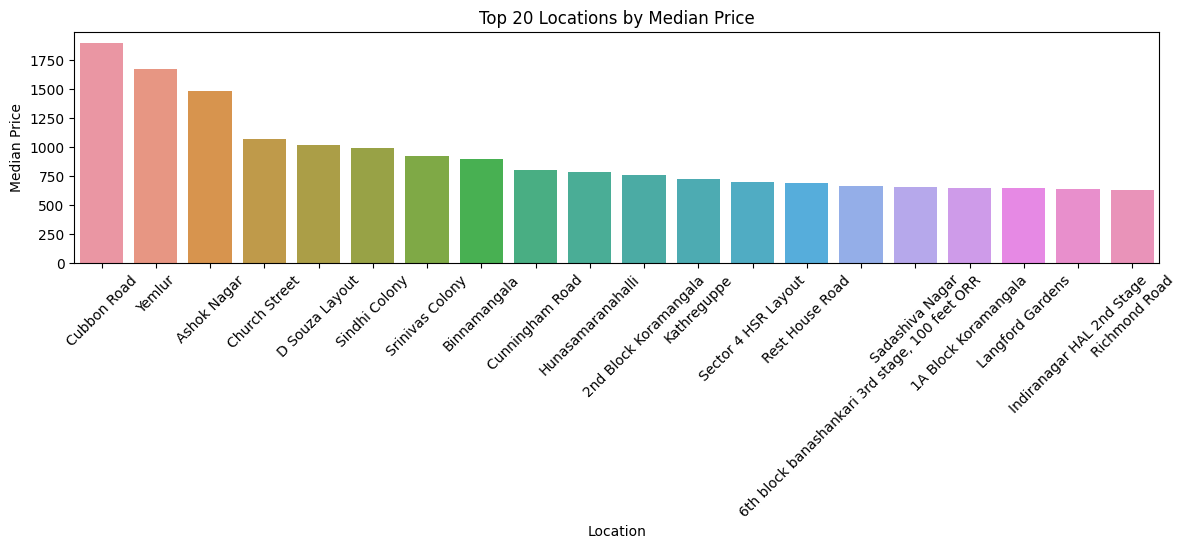

In [8]:
# Plotting top 20 locations by median price
plt.figure(figsize=(14, 3))
sns.barplot(x=top_locations.index, y=top_locations.values)
plt.title('Top 20 Locations by Median Price')
plt.xlabel('Location')
plt.ylabel('Median Price')
plt.xticks(rotation=45)
plt.show()

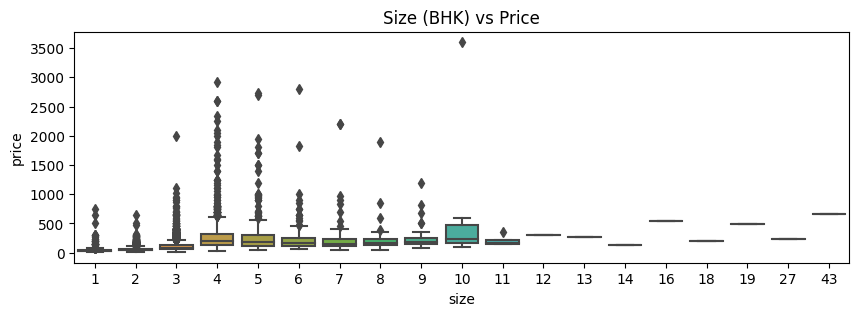

In [9]:
# Plotting 'size' vs 'price'
plt.figure(figsize=(10, 3))
sns.boxplot(x='size', y='price', data=data)
plt.title('Size (BHK) vs Price')
plt.show()

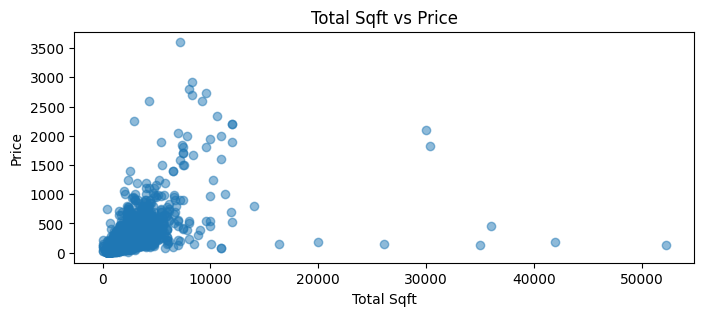

In [10]:
# Plotting 'total_sqft' vs 'price'
plt.figure(figsize=(8, 3))
plt.scatter(data['total_sqft'], data['price'], alpha=0.5)
plt.title('Total Sqft vs Price')
plt.xlabel('Total Sqft')
plt.ylabel('Price')
plt.show()

# Feature Engineering & Encoding

In [11]:
# Convert 'availability' to numerical format
def availability_to_num(x):
    if x == 'Ready To Move':
        return 0
    elif x == 'Immediate Possession':
        return 1
    try:
        # Check if x is a date and convert it to numerical format (e.g., the year part)
        return 2
    except:
        return 2

data['availability'] = data['availability'].apply(availability_to_num)

# Map 'area_type' to specified values
area_type_mapping = {
    'Carpet  Area': 1,
    'Plot  Area': 2,
    'Built-up  Area': 3,
    'Super built-up  Area': 4
}
data['area_type'] = data['area_type'].map(area_type_mapping).fillna(0).astype(int)

# One-hot encode 'location'
data = pd.get_dummies(data, columns=['location'], drop_first=True)

# Convert all columns to integer where possible
data = data.apply(pd.to_numeric, errors='ignore')

#Remove rows with Nan values
data = data.dropna()

/tmp/ipykernel_34/2939251551.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.apply(pd.to_numeric, errors='ignore')


# Remove Outliers and Split Data

In [12]:
# Filter out rows where 'price' is above 500
data_filtered = data[data['price'] <= 500]

# Separate features and target variable
X = data_filtered.drop(columns=['price', 'society'])
y = data_filtered['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train RandomForestRegressor and Evaluate

Mean Squared Error: 1594.744216630779


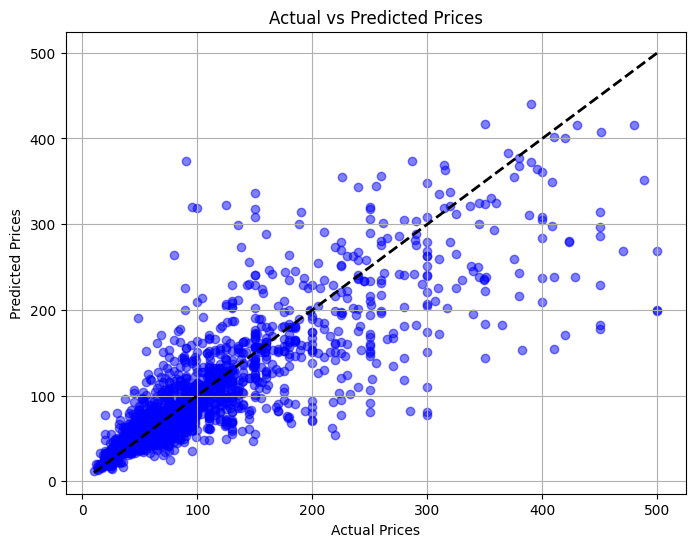

In [13]:
# Initialize the RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=42)

# Train RandomForestRegressor on cleaned data
rf_regressor.fit(X_train, y_train)

# Predict on test set
y_pred = rf_regressor.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plotting actual vs predicted after removing outliers
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.grid(True)
plt.show()

# Save the Trained Model

In [14]:
import joblib

# Save the trained RandomForestRegressor model
joblib_file = "random_forest_model.pkl"
joblib.dump(rf_regressor, joblib_file)

print(f"Model saved as {joblib_file}")

Model saved as random_forest_model.pkl
